# Train the operator action prediction model with w2v

## 1. Prepare the dataloaders for training and test

In [1]:
import data
import keras
import pandas as pd
import numpy as np
import setGPU

Using TensorFlow backend.


setGPU: Setting GPU to: 0


In [2]:
# Clas to load the data
class LogData(data.Data):
    
    def load_data(self, in_file):

        """Loads numpy arrays from H5 pandas file 
            TODO: check preloading"""
        
        h5_file = pd.read_hdf( in_file )
        X1 = h5_file['table_flattened'].values
        X1 = np.array(list(X1))
        Y = h5_file['action_binary_encoded'].values
        print len(X1)
        return X1,Y

In [9]:
# Randomly shuffle the input files for the training and testing

file_ids = range(0, 26)

import random
SEED = 30

random.seed(SEED)
random.shuffle(file_ids)

print file_ids
train_ids = file_ids[0:14]
test_ids = file_ids[14:18]
print train_ids
print test_ids

[10, 11, 2, 6, 18, 13, 21, 16, 8, 20, 9, 1, 23, 3, 25, 22, 19, 17, 12, 24, 5, 4, 15, 0, 7, 14]
[10, 11, 2, 6, 18, 13, 21, 16, 8, 20, 9, 1, 23, 3]
[25, 22, 19, 17]


In [10]:
# File names for the training and test
inFiles_train = []
inFiles = []
path = '/bigdata/shared/AIErrorHandling/'
for i in train_ids:
    inFiles_train.append(path + 'w2v_matrix' + str(i) + '.h5')
inFiles_test = []
for i in test_ids:
    inFiles_test.append(path + 'w2v_matrix' + str(i) + '.h5')
for i in file_ids:
    inFiles.append(path + 'w2v_matrix' + str(i) + '.h5')

In [11]:
batch_size = 10
loader_train = LogData(batch_size=batch_size)
loader_test = LogData(batch_size=batch_size)
loader_train.set_file_names(inFiles_train)
loader_test.set_file_names(inFiles_test)
loader = LogData(batch_size=batch_size)
loader.set_file_names(inFiles)

In [12]:
print loader_train.file_names

['/bigdata/shared/AIErrorHandling/w2v_matrix10.h5', '/bigdata/shared/AIErrorHandling/w2v_matrix11.h5', '/bigdata/shared/AIErrorHandling/w2v_matrix2.h5', '/bigdata/shared/AIErrorHandling/w2v_matrix6.h5', '/bigdata/shared/AIErrorHandling/w2v_matrix18.h5', '/bigdata/shared/AIErrorHandling/w2v_matrix13.h5', '/bigdata/shared/AIErrorHandling/w2v_matrix21.h5', '/bigdata/shared/AIErrorHandling/w2v_matrix16.h5', '/bigdata/shared/AIErrorHandling/w2v_matrix8.h5', '/bigdata/shared/AIErrorHandling/w2v_matrix20.h5', '/bigdata/shared/AIErrorHandling/w2v_matrix9.h5', '/bigdata/shared/AIErrorHandling/w2v_matrix1.h5', '/bigdata/shared/AIErrorHandling/w2v_matrix23.h5', '/bigdata/shared/AIErrorHandling/w2v_matrix3.h5']


## 2. Set up the model 

In [13]:
X = []
Y = []
for x,y in loader.generate_data():
    
    X.append(x)
    Y.append(y)


1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
90
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


In [14]:
Y = np.concatenate(Y)
X = np.concatenate(X)

In [15]:
X.shape[2]

(25090, 64, 1661)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

14000


### Simple fully connected dense 

In [55]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Dropout
from keras.regularizers import l1, l2
from keras.constraints import maxnorm
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import backend as K
import tensorflow as tf
from sklearn.metrics import roc_auc_score


def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

#def auroc(y_true, y_pred):
#    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

model = Sequential()
model.add(Flatten(input_shape=(151, 704)))
model.add(Dense(100,    activation='relu' ) )
model.add(Dropout(0.5))
model.add(Dense(100,    activation='relu' ) )
model.add(Dropout(0.5))
model.add(Dense(100,    activation='relu' ) )
model.add(Dropout(0.5))
model.add( Dense( 1 , activation='sigmoid' ) )
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0), 
              metrics=['accuracy', auc])

In [18]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_1 (Flatten)              (None, 106304)        0           flatten_input_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 100)           10630500    flatten_1[0][0]                  
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 100)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 100)           10100       dropout_1[0][0]                  
___________________________________________________________________________________________

In [ ]:
help(Sequential.fit_generator)

In [36]:
print len(loader_train.file_names)

14


In [205]:
model.fit_generator(loader_train.generate_data(), samples_per_epoch=13000, nb_epoch=13)

NameError: name 'test_X' is not defined

In [257]:
batch_size=100
epochs=200
validation_split=0.0
verbose=1
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epochs, validation_split=validation_split )

Epoch 1/200
12985/12985 [==============================] - 16s - loss: 0.3251 - acc: 0.9344 - auc: 0.5021    
Epoch 2/200
12985/12985 [==============================] - 15s - loss: 0.2561 - acc: 0.9386 - auc: 0.5533    
Epoch 3/200
12985/12985 [==============================] - 15s - loss: 0.2449 - acc: 0.9386 - auc: 0.5853    
Epoch 4/200
12985/12985 [==============================] - 15s - loss: 0.2377 - acc: 0.9386 - auc: 0.6039    
Epoch 5/200
12985/12985 [==============================] - 15s - loss: 0.2344 - acc: 0.9386 - auc: 0.6184    
Epoch 6/200
12985/12985 [==============================] - 15s - loss: 0.2305 - acc: 0.9385 - auc: 0.6306    
Epoch 7/200
12985/12985 [==============================] - 15s - loss: 0.2284 - acc: 0.9387 - auc: 0.6399    
Epoch 8/200
12985/12985 [==============================] - 15s - loss: 0.2232 - acc: 0.9385 - auc: 0.6487    
Epoch 9/200
12985/12985 [==============================] - 15s - loss: 0.2232 - acc: 0.9385 - auc: 0.6567    
Epoch 10/2

12985/12985 [==============================] - 15s - loss: 0.1500 - acc: 0.9565 - auc: 0.8457    
Epoch 148/200
12985/12985 [==============================] - 15s - loss: 0.1475 - acc: 0.9566 - auc: 0.8460    
Epoch 149/200
12985/12985 [==============================] - 15s - loss: 0.1528 - acc: 0.9563 - auc: 0.8463    
Epoch 150/200
12985/12985 [==============================] - 15s - loss: 0.1508 - acc: 0.9556 - auc: 0.8467    
Epoch 151/200
12985/12985 [==============================] - 15s - loss: 0.1461 - acc: 0.9558 - auc: 0.8470    
Epoch 152/200
12985/12985 [==============================] - 15s - loss: 0.1463 - acc: 0.9571 - auc: 0.8473    
Epoch 153/200
12985/12985 [==============================] - 15s - loss: 0.1511 - acc: 0.9550 - auc: 0.8476    
Epoch 154/200
12985/12985 [==============================] - 15s - loss: 0.1493 - acc: 0.9568 - auc: 0.8479    
Epoch 155/200
12985/12985 [==============================] - 15s - loss: 0.1510 - acc: 0.9553 - auc: 0.8482    
Epoch 

In [258]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

In [259]:
print roc_auc_score(y_test, y_pred)
print roc_auc_score(y_train, y_train_pred)

0.667391830991
0.926968655843


In [156]:
y_true = []
y_pred = []
for X,Y in loader_test.generate_data():
    
    pred = model.predict(X)
    y_pred.append(pred)
    y_true.append(Y)

1000
554
1000
1000


In [159]:
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

In [160]:
print len(y_pred)

3550


In [199]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
def ROC(y_test, y_pred):
    """
    plot ROC curve for test dataset
    """
    roc_fpr, roc_tpr, roc_thresholds = roc_curve(y_test, y_pred.ravel() )
    roc_auc = auc(roc_fpr , roc_tpr)

    roc_plot = plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(roc_fpr, roc_tpr, label='Keras (area = {:.3f})'.format(roc_auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

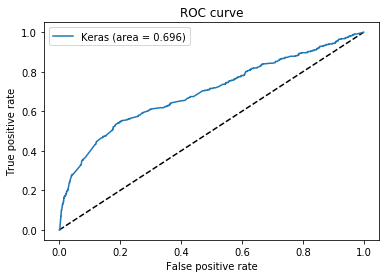

In [201]:
ROC(y_test, y_pred)

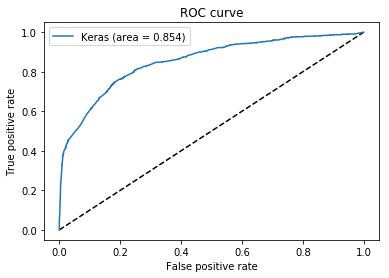

In [202]:
ROC(y_train, y_train_pred)

In [61]:
predict = model.predict_generator(loader.generate_data(), val_samples = 100)

In [59]:
print predict

[[  6.80308864e-02]
 [  5.93945794e-02]
 [  5.93945794e-02]
 [  5.70535362e-02]
 [  5.93945794e-02]
 [  1.69053573e-11]
 [  5.52369654e-02]
 [  6.26947135e-02]
 [  5.47897518e-02]
 [  5.96414208e-02]
 [  5.96414208e-02]
 [  5.96414208e-02]
 [  6.33787662e-02]
 [  6.33787662e-02]
 [  5.96414208e-02]
 [  6.98937923e-02]
 [  4.41190079e-02]
 [  3.71050090e-02]
 [  6.26947135e-02]
 [  5.49029410e-02]
 [  6.79483637e-02]
 [  6.52811527e-02]
 [  6.51219934e-02]
 [  6.45904243e-02]
 [  6.21460564e-02]
 [  6.64102063e-02]
 [  5.97147234e-02]
 [  6.58985972e-02]
 [  6.29624352e-02]
 [  6.43922538e-02]
 [  6.52675927e-02]
 [  6.45904243e-02]
 [  6.58985972e-02]
 [  7.08941116e-06]
 [  6.96100891e-02]
 [  6.70144111e-02]
 [  6.52664080e-02]
 [  6.52664080e-02]
 [  6.28675967e-02]
 [  7.17234686e-02]
 [  9.32889432e-02]
 [  5.84310293e-02]
 [  6.67389706e-02]
 [  6.40776902e-02]
 [  6.67389706e-02]
 [  6.67389706e-02]
 [  5.87887019e-02]
 [  6.62752837e-02]
 [  6.88263178e-02]
 [  6.28458261e-02]


In [60]:
help(Sequential.predict_generator)

Help on method predict_generator in module keras.models:

predict_generator(self, generator, val_samples, max_q_size=10, nb_worker=1, pickle_safe=False) unbound keras.models.Sequential method
    Generates predictions for the input samples from a data generator.
    The generator should return the same kind of data as accepted by
    `predict_on_batch`.
    
    # Arguments
        generator: generator yielding batches of input samples.
        val_samples: total number of samples to generate from `generator`
            before returning.
        max_q_size: maximum size for the generator queue
        nb_worker: maximum number of processes to spin up
        pickle_safe: if True, use process based threading. Note that because
            this implementation relies on multiprocessing, you should not pass non
            non picklable arguments to the generator as they can't be passed
            easily to children processes.
    
    # Returns
        A Numpy array of predictions.



In [ ]:
model.fit_generator(myGenerator(), samples_per_epoch = 60000, nb_epoch = 2, verbose=2, show_accuracy=True, callbacks=[], validation_data=None, class_weight=None, nb_worker=1)


In [214]:
X.shape

(18550, 151, 704)

In [215]:
X_swp = np.swapaxes(X,0,1)

In [281]:
X_swp.shape[1]

18550

In [50]:
from keras.layers import Input, LSTM, Dense, merge
from keras.models import Model
#dim1 = len(features[0][0])
#dim2 = len(features)
dim1 = X.shape[2]

dense = Dense(100, activation = "relu", init="normal")
ip_shapes = []
op_shapes = []
for i in range(X.shape[1]):
    ip_shape = ( Input(shape=(dim1,)) )
    ip_shapes.append(ip_shape)
    op_shapes.append( dense(ip_shape))

merged_vector = merge(op_shapes, mode='ave', concat_axis=-1)

hidden1 = Dense(100, activation = "relu", init="normal")(merged_vector)
hidden2 = Dense(100, activation = "relu", init="normal")(hidden1)
hidden3 = Dense(100, activation = "relu", init="normal")(hidden2)
hidden4 = Dense(100, activation = "relu", init="normal")(hidden3)
# and add a logistic regression on top
predictions = Dense(1, activation='sigmoid')(hidden4)

# we define a trainable model linking the
# tweet inputs to the predictions
model = Model(input = ip_shapes, output=predictions)

model.compile(loss='binary_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0), 
              metrics=['accuracy', auc])

"""
dense = Dense(1, activation = "sigmoid", kernel_initializer = "ones")

op1 = dense(ip_shape1)
op2 = dense(ip_shape2)

merge_layer = keras.layers.concatenate([op1, op2])
predictions = Dense(1, activation='sigmoid')(merge_layer)

model = Model(inputs=[ip_shape1, ip_shape2], outputs=predictions)
"""

'\ndense = Dense(1, activation = "sigmoid", kernel_initializer = "ones")\n\nop1 = dense(ip_shape1)\nop2 = dense(ip_shape2)\n\nmerge_layer = keras.layers.concatenate([op1, op2])\npredictions = Dense(1, activation=\'sigmoid\')(merge_layer)\n\nmodel = Model(inputs=[ip_shape1, ip_shape2], outputs=predictions)\n'

In [51]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_385 (InputLayer)           (None, 1661)          0                                            
____________________________________________________________________________________________________
input_386 (InputLayer)           (None, 1661)          0                                            
____________________________________________________________________________________________________
input_387 (InputLayer)           (None, 1661)          0                                            
____________________________________________________________________________________________________
input_388 (InputLayer)           (None, 1661)          0                                            
___________________________________________________________________________________________

In [45]:
X_train_swp = np.swapaxes(X_train,0,1)

In [46]:
inputs = []
for i in range(X_train_swp.shape[0]):
    inputs.append(X_train_swp[i])

In [52]:
batch_size=100
epochs=200
model.fit(inputs, y_train, batch_size = batch_size, nb_epoch=epochs)

Epoch 1/200
17563/17563 [==============================] - 13s - loss: 0.2867 - acc: 0.9354 - auc: 0.4795    
Epoch 2/200
17563/17563 [==============================] - 13s - loss: 0.2317 - acc: 0.9391 - auc: 0.5060    
Epoch 3/200
17563/17563 [==============================] - 12s - loss: 0.2285 - acc: 0.9391 - auc: 0.5221    
Epoch 4/200
17563/17563 [==============================] - 12s - loss: 0.2251 - acc: 0.9391 - auc: 0.5426    
Epoch 5/200
17563/17563 [==============================] - 13s - loss: 0.2189 - acc: 0.9391 - auc: 0.5707    
Epoch 6/200
17563/17563 [==============================] - 13s - loss: 0.2163 - acc: 0.9391 - auc: 0.5932    
Epoch 7/200
17563/17563 [==============================] - 12s - loss: 0.2155 - acc: 0.9391 - auc: 0.6112    
Epoch 8/200
17563/17563 [==============================] - 12s - loss: 0.2130 - acc: 0.9391 - auc: 0.6256    
Epoch 9/200
17563/17563 [==============================] - 12s - loss: 0.2121 - acc: 0.9391 - auc: 0.6378    
Epoch 10/2

17563/17563 [==============================] - 13s - loss: 0.1362 - acc: 0.9585 - auc: 0.8499    
Epoch 148/200
17563/17563 [==============================] - 13s - loss: 0.1342 - acc: 0.9583 - auc: 0.8503    
Epoch 149/200
17563/17563 [==============================] - 13s - loss: 0.1406 - acc: 0.9564 - auc: 0.8506    
Epoch 150/200
17563/17563 [==============================] - 13s - loss: 0.1354 - acc: 0.9577 - auc: 0.8510    
Epoch 151/200
17563/17563 [==============================] - 13s - loss: 0.1344 - acc: 0.9582 - auc: 0.8513    
Epoch 152/200
17563/17563 [==============================] - 13s - loss: 0.1344 - acc: 0.9576 - auc: 0.8517    
Epoch 153/200
17563/17563 [==============================] - 13s - loss: 0.1334 - acc: 0.9582 - auc: 0.8520    
Epoch 154/200
17563/17563 [==============================] - 13s - loss: 0.1334 - acc: 0.9591 - auc: 0.8524    
Epoch 155/200
17563/17563 [==============================] - 13s - loss: 0.1352 - acc: 0.9583 - auc: 0.8527    
Epoch 

In [53]:
X_test_swp = np.swapaxes(X_test,0,1)
inputs_test = []
for i in range(X_test_swp.shape[0]):
    inputs_test.append(X_test_swp[i])

y_pred = model.predict(inputs_test)
y_train_pred = model.predict(inputs)

In [54]:
print roc_auc_score(y_test, y_pred)
print roc_auc_score(y_train, y_train_pred)

0.666282971802
0.914226964597


In [56]:
from keras.layers import Input, LSTM, Dense, merge
from keras.models import Model

tweet_a = Input(shape=(140, 256))
tweet_b = Input(shape=(140, 256))
# this layer can take as input a matrix
# and will return a vector of size 64
shared_lstm = LSTM(64)

# when we reuse the same layer instance
# multiple times, the weights of the layer
# are also being reused
# (it is effectively *the same* layer)
encoded_a = shared_lstm(tweet_a)
encoded_b = shared_lstm(tweet_b)

encoded = [encoded_a, encoded_b]

# we can then concatenate the two vectors:
merged_vector = merge(encoded, mode='concat', concat_axis=-1)

# and add a logistic regression on top
predictions = Dense(1, activation='sigmoid')(merged_vector)

# we define a trainable model linking the
# tweet inputs to the predictions
model = Model(input=[tweet_a, tweet_b], output=predictions)